In [1]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# **MEME-ChIP Report**
***
## **DREME** 
- Searches for **short**, ungapped motifs, relatively enriched vs background (flanking regions)
- TOMTOM compares discovered motifs against database(s) of known motifs

In [2]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [3]:
def motif_lookup(db):
    
    with open("./pipeline.ini", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [4]:
def dreme_summary(db, conditions="", widths="", no_peaks="", samples=""):

    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    df = []
    n = 0
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"


                    # get corresponding meme e_values for discovered motifs from meme.txt
                    meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/dreme_out/dreme.txt"
                    if os.path.exists(meme_out):
                        with open(meme_out, "r") as open_meme:
                            l = 0
                            for line in open_meme:
                                motif = re.findall("^#.*", line)
                                if len(motif) > 0:
                                    l = l + 1
                                    if l > 6:
                                        motif =  [ x for x in motif if "Stopping" not in x]
                                        motif =  [ x for x in motif if "Running" not in x]
                                        motif =  [ x for x in motif if "Word" not in x]
                                        if len(motif) > 0:
                                            motif = [x for x in ''.join(motif).split() if x not in ["BEST", "#"]]
                                            motif.append(table.replace("_Dreme_tomtom", ""))
                                            df.append(motif)

    df = pd.DataFrame(df, columns = ["motif", "motif_rc", "pos", "neg", "p_value", "dreme_evalue", "run"])
    df.drop("p_value", inplace=True, axis=1)
#     df = df.drop_duplicates()

    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("dreme_motifs", connect, if_exists="replace", index=False)

    return df

dreme = dreme_summary(db, conditions=["increase", "decrease"])

In [5]:
def dremechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"

                    if tables["tables"].str.contains(table).any():

                        statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                    b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                    from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                    order by e_value asc''' % locals()

                        df = DB.fetch_DataFrame(statement, db)
                        df = df.drop_duplicates()
                        df["run"] = str(table).rstrip("_Dreme_tomtom")
                        df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                        df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                        df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                        df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                        dfs.append(df)


    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
        motifs.head()
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

motifs = dremechip_summary(db, conditions=["increase", "decrease"])

In [6]:
def analyse_dreme(motifs, dreme):

    # reformat dfs for merge
    motifs.rename(columns={"query_id":"motif"}, inplace=True)

    # merge dfs
    dreme_chip = pd.merge(dreme, motifs, how="inner", on=["run", "motif"])
    dreme_chip.drop_duplicates(inplace=True)

    dreme_chip["dreme_evalue"] = dreme_chip["dreme_evalue"].apply(lambda x: float(x)) # correct type
    dreme_chip["settings"] = dreme_chip["no_peaks"] + "_" + dreme_chip["window"] # make column for plot annotations

    # subset on sig motifs & sig matches
    dreme_chip = dreme_chip[(dreme_chip.tomtom_evalue < 0.05) & (dreme_chip.dreme_evalue < 0.05)].sort_values(["dreme_evalue", "tomtom_evalue"], ascending=True)
    dreme_chip = dreme_chip[dreme_chip["dreme_evalue"] != 0]
    dreme_chip = dreme_chip[dreme_chip["tomtom_evalue"] != 0]
    
    return dreme_chip

dreme_chip = analyse_dreme(motifs, dreme)

## Effect of MEME-ChIP Settings on DREME & TOMTOM

In [7]:
# make new df for plots
dreme_evalue = dreme_chip.copy(deep=True)
dreme_evalue.index.name = None
dreme_evalue.reset_index(inplace=True, drop=True)
dreme_evalue = dreme_evalue.drop_duplicates(["target_id", "motif_name", "run", "motif"], keep="first")

In [8]:
%%R -i dreme_evalue

a <- ggplot(dreme_evalue, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), shape=factor(query_id), alpha=condition, colour=database)) +
        geom_jitter(size=3) + 
        scale_alpha_discrete(range=c(0.4, 1)) +
        facet_grid(settings ~ DESeq2_comparison) +
        theme(legend.position="bottom", legend.direction="horizontal")
        
b <- ggplot(dreme_evalue, aes(y=-log10(dreme_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=dreme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Dreme motif discovery", x="Peak width")
        
c <- ggplot(dreme_evalue, aes(y=-log10(tomtom_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=dreme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif comparison", x="Peak width")

In [9]:
dreme_motif_no = dreme_evalue.groupby(["run", "window", "no_peaks"]).agg({"motif_name":"count"})
dreme_motif_no.reset_index(inplace=True)

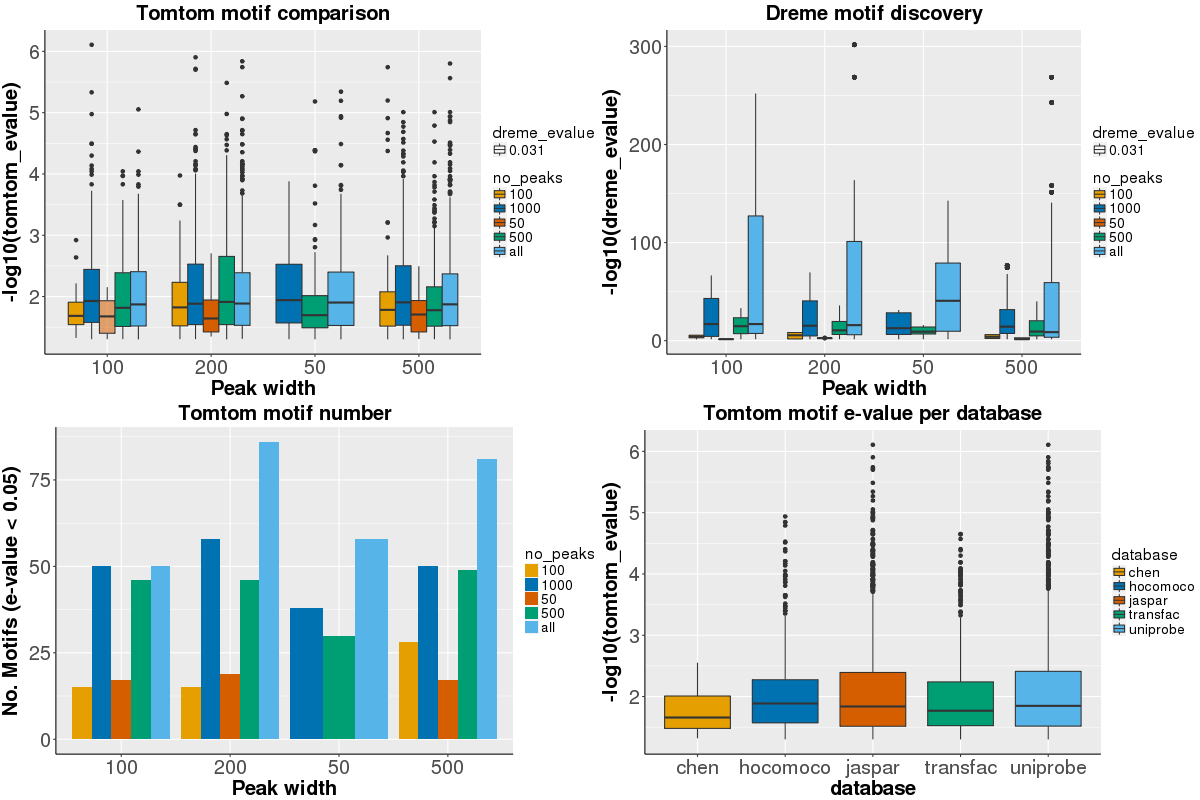

In [10]:
%%R -i dreme_motif_no,dreme_chip -w 1200 -h 800

# meme_motif_no <- meme_motif_no[order(meme_motif_no$motif_name, descending=TRUE), ]
d <- ggplot(dreme_motif_no, aes(y=motif_name, x=window, fill=no_peaks)) + 
        geom_bar(stat="identity", position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif number", x="Peak width", y="No. Motifs (e-value < 0.05)")# +
#         scale_x_discrete(limits=unique(meme_motif_no$window))
        
e <- ggplot(dreme_chip, aes(y=-log10(tomtom_evalue), x=database, fill=database)) + 
        geom_boxplot() +
        scale_fill_manual(values=Palette) +
        labs(title="Tomtom motif e-value per database")
        
grid.arrange(c, b, d, e, ncol=2, nrow=2)

## DREME-ChIP Summary
* For simplicity results from all MEME-ChIP runs are aggregated
    * TOMTOM & DREME e-values are averaged across runs
    * No. motif occurances between runs and databases is counted
    * All DREME motifs have an e-value < 0.05
* This is to provide an overview of the data, do not use for downstream analysis

In [11]:
# aggregate data
dreme_summary = dreme_chip.groupby(["target_id", "motif_name", "motif", "DESeq2_comparison", "condition"]).agg({"tomtom_evalue":"mean", "dreme_evalue":"mean", "run":"count", "database":"count"})
dreme_summary.reset_index(inplace=True)

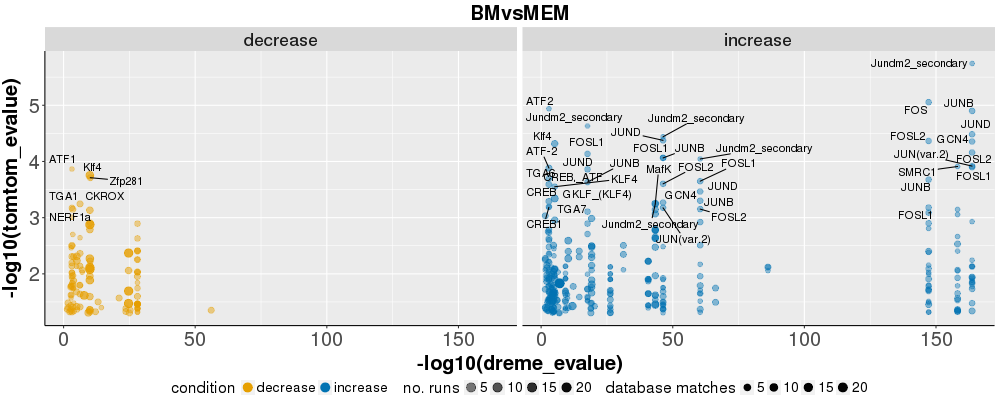

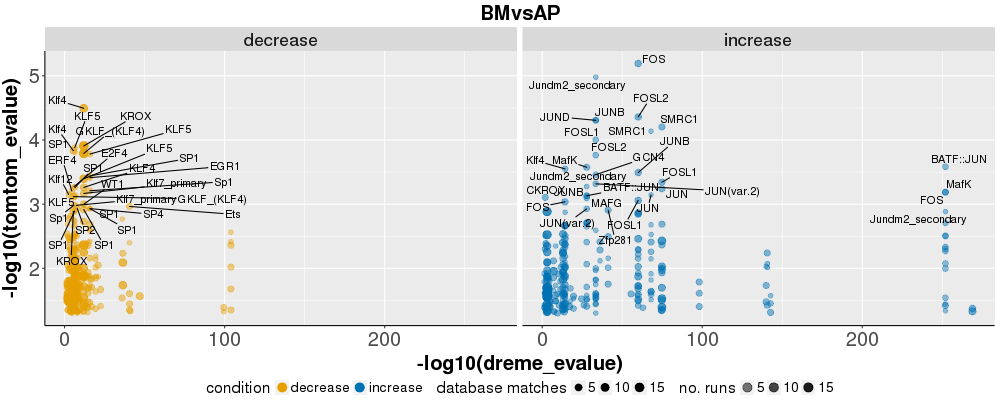

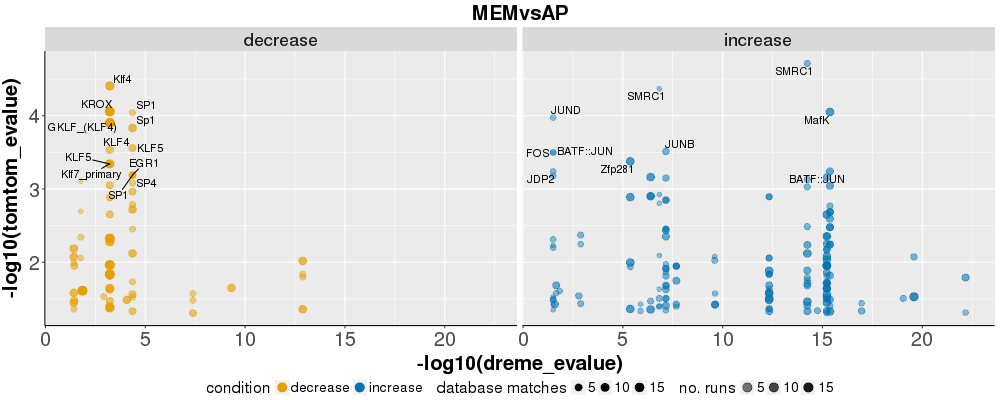

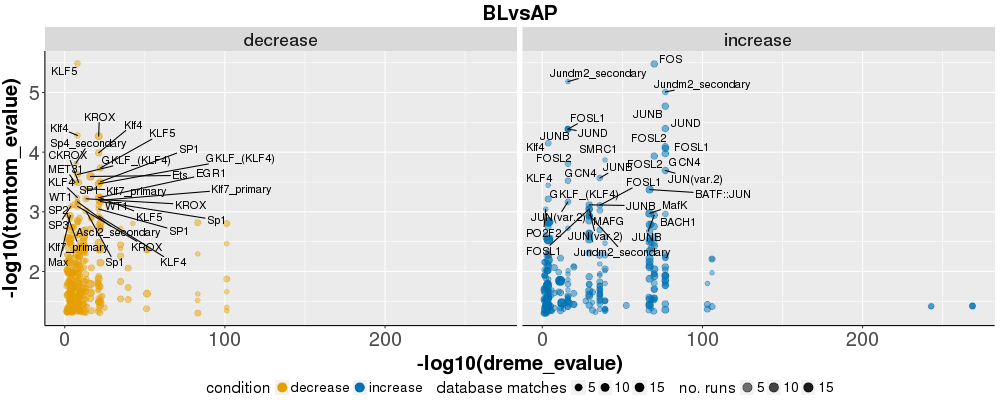

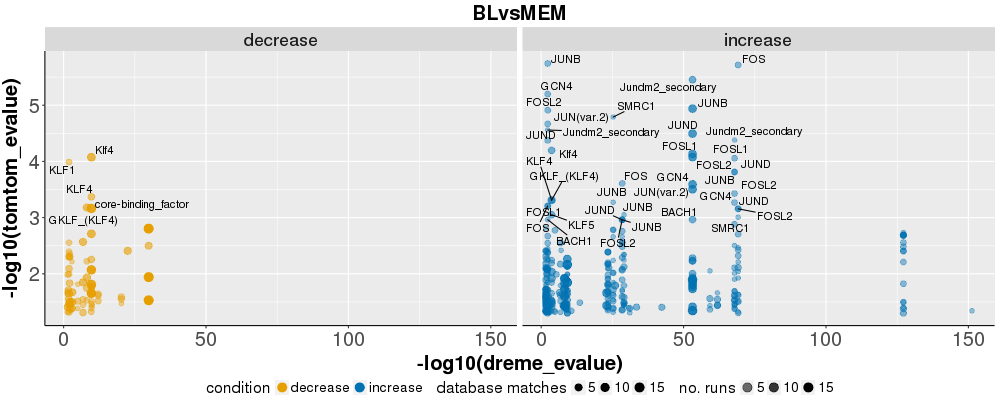

In [12]:
%%R -i dreme_summary -w 1000 -h 400

for (comp in unique(dreme_summary$DESeq2_comparison)){

    df <- subset(dreme_summary, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), alpha=run, colour=condition)) +
            geom_point(aes(size=database), position=position_jitterdodge()) + 
            scale_size(range=c(2,4), name="database matches") +
            scale_alpha(range=c(0.4,1), name="no. runs") +
            scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
            geom_text_repel(
                data=df[-log10(df$tomtom_evalue) > 
                          quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                aes(label=motif_name), colour="black", alpha=1, position=position_jitterdodge()) +
            facet_wrap(~ condition) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            scale_colour_manual(values=Palette) +
            guides(color=guide_legend(override.aes=list(size=4)), alpha=guide_legend(override.aes=list(size=4))) +
            labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

## DREME & TOMTOM Results for Each Run & Sample
* Mutliple database hits for the same motif discovered by DREME are merged (TOMTOM e-values are averaged)

In [13]:
# make new df for plot
dreme_graph = dreme_chip.copy(deep=True)

# count occurnaces of the same motif matching a TF in many databases
# average tomtom_evalue in these instances
dreme_graph = dreme_graph.groupby(["target_id", "motif_name", "motif","orientation", "run", "DESeq2_comparison", "condition", "settings"]).agg({"database":"count", "dreme_evalue":"min", "tomtom_evalue":"mean"})
dreme_graph.reset_index(inplace=True)

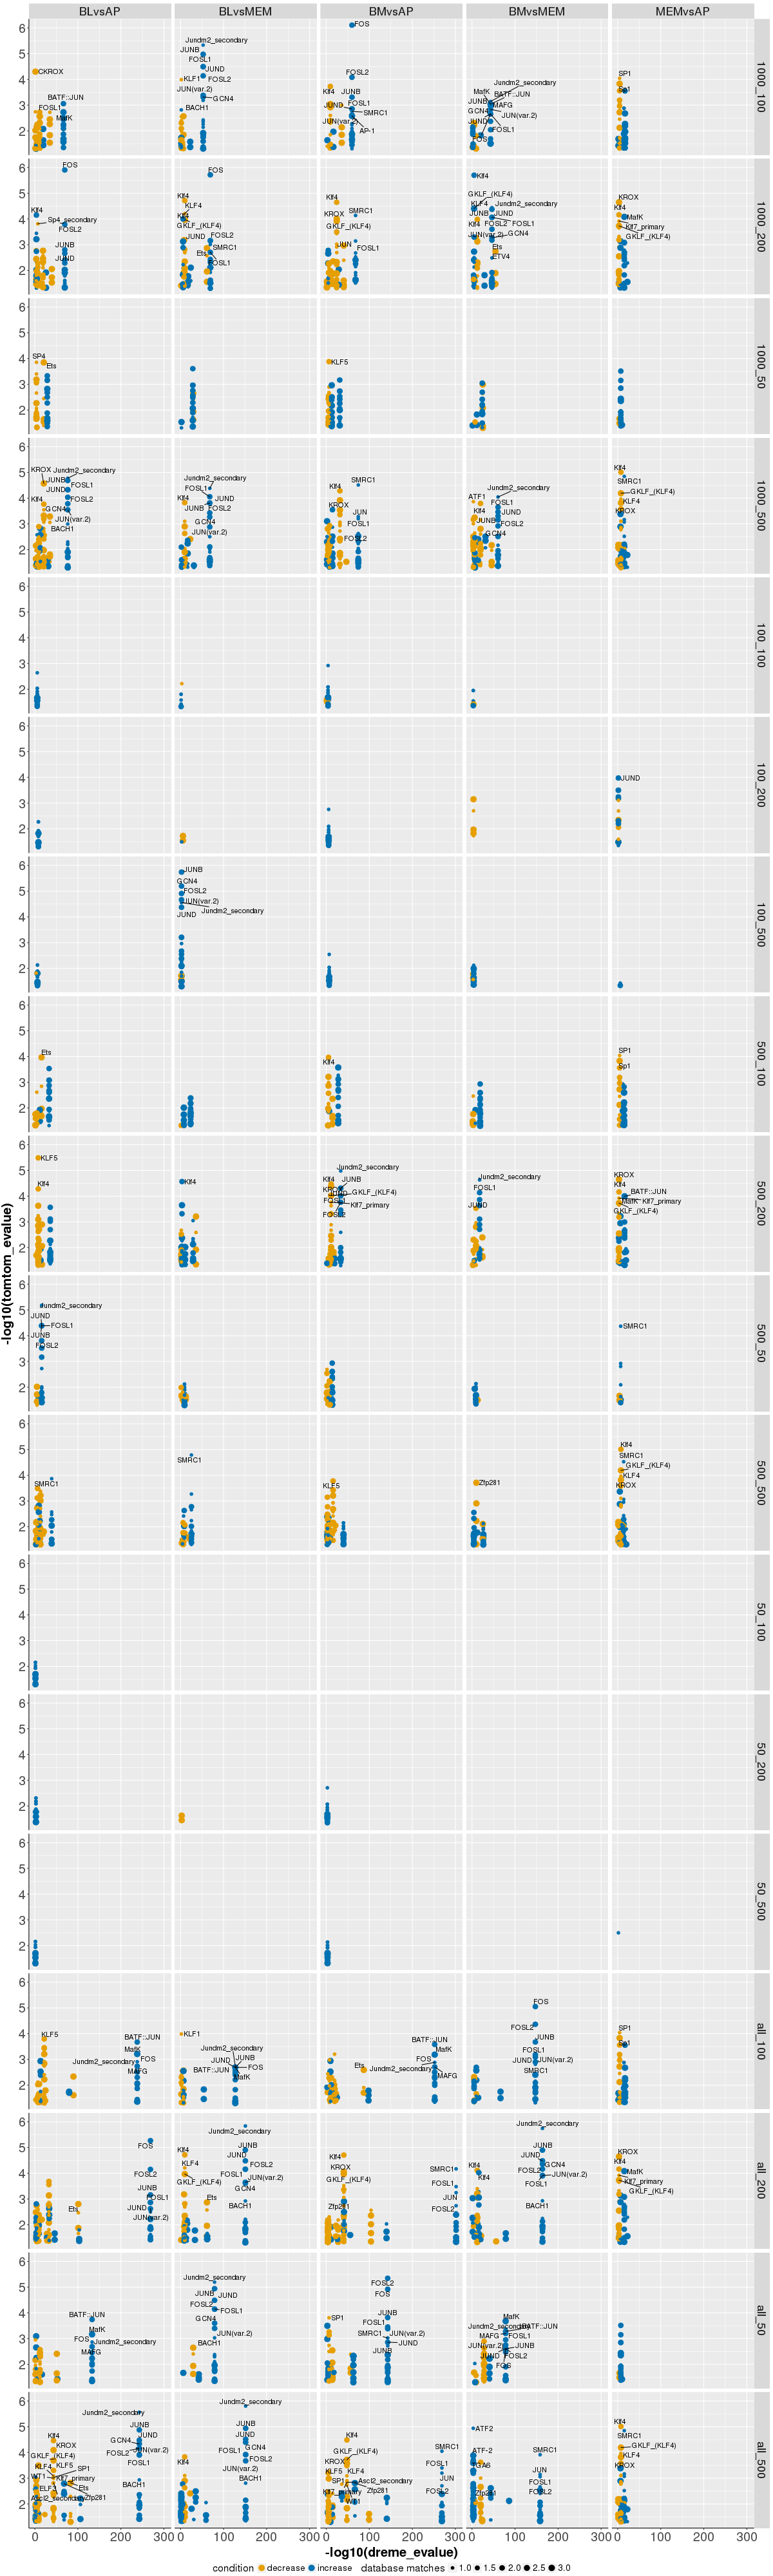

In [14]:
%%R -i dreme_graph -w 1200 -h 4000

ggplot(dreme_graph, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), colour=condition)) +
    geom_jitter(aes(size=database)) + 
    scale_size(range=c(2,4), name="database matches") +
    geom_text_repel(data=dreme_graph[-log10(dreme_graph$"dreme_evalue") > 
                                   quantile(-log10(dreme_graph$"dreme_evalue"), 0.8, na.rm=T) &
                                   -log10(dreme_graph$"tomtom_evalue") > 
                                   quantile(-log10(dreme_graph$"tomtom_evalue"), 0.8, na.rm=T) |#, ], 
                                   -log10(dreme_graph$"dreme_evalue") > quantile(-log10(dreme_graph$"dreme_evalue"), 0.95, na.rm=T)  &
                                   -log10(dreme_graph$"tomtom_evalue") > 
                                   quantile(-log10(dreme_graph$"tomtom_evalue"), 0.9, na.rm=T) |
                                   -log10(dreme_graph$"tomtom_evalue") > quantile(-log10(dreme_graph$"tomtom_evalue"), 0.95, na.rm=T), ], 
                    aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), label=motif_name), colour="black") +
    facet_grid(settings ~ DESeq2_comparison) +
    theme(legend.position="bottom", legend.direction="horizontal") +
    scale_colour_manual(values=Palette) +
    guides(color=guide_legend(override.aes=list(size=4))) +
    guides(shape=guide_legend(override.aes=list(size=4)))

### Top Database Matches per DREME Motif 
* All discovered motifs have e-value < 0.05
* Multiple database matches for DREME motifs are grouped by TF name & TOMTOM e-values averaged

In [15]:
# make extra cols for annotation
dreme_graph["width"] = dreme_graph["settings"].apply(lambda x: "width_" + x.split("_")[1])
dreme_graph["peaks"] = dreme_graph["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])

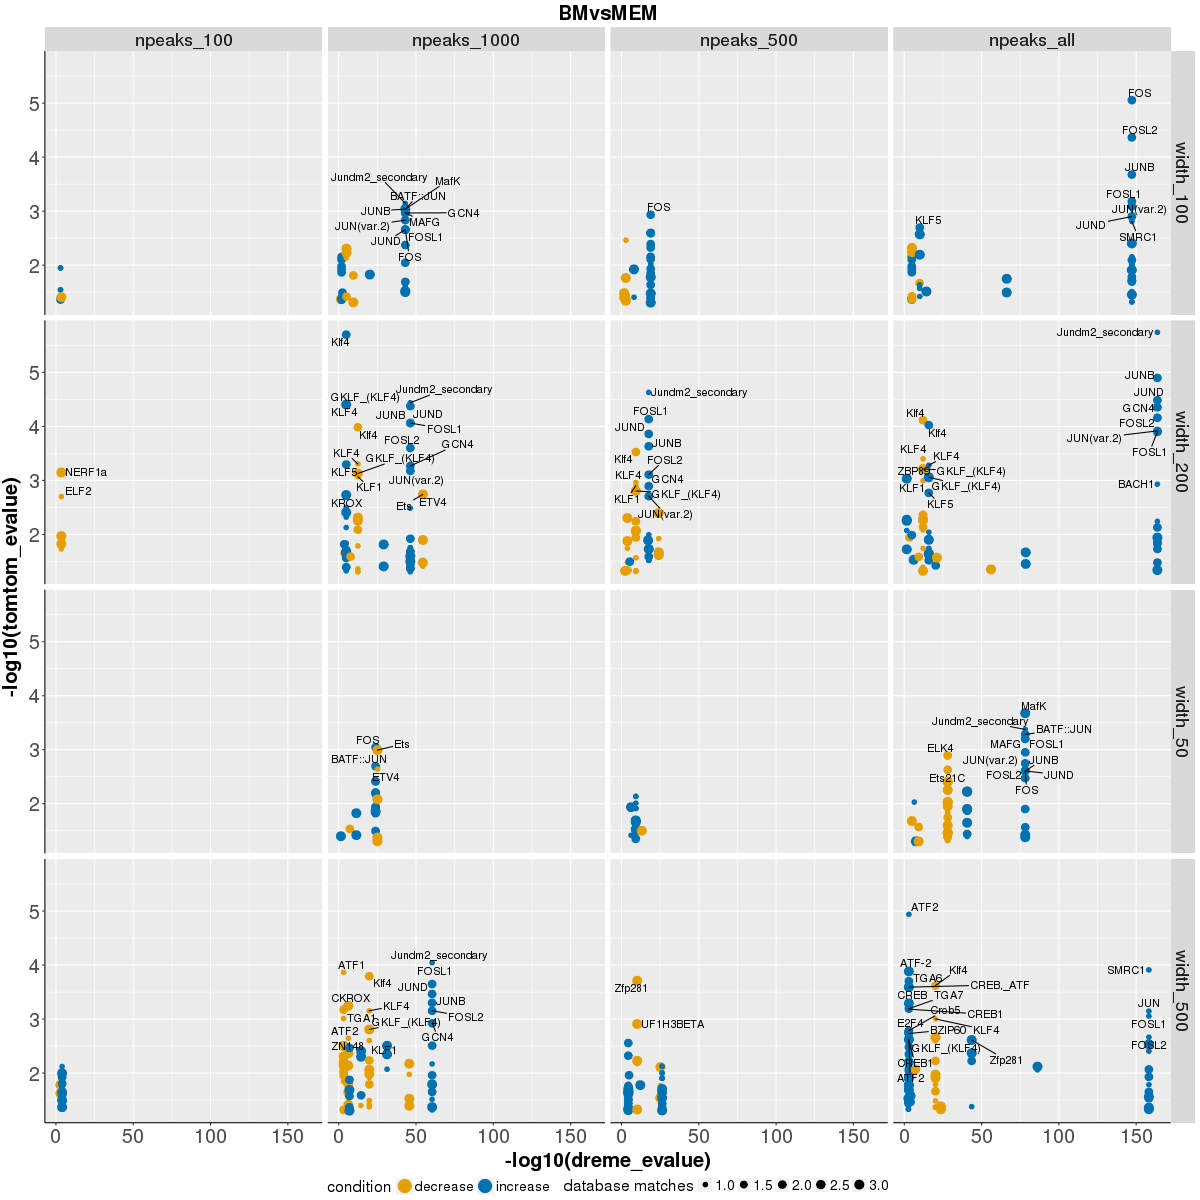

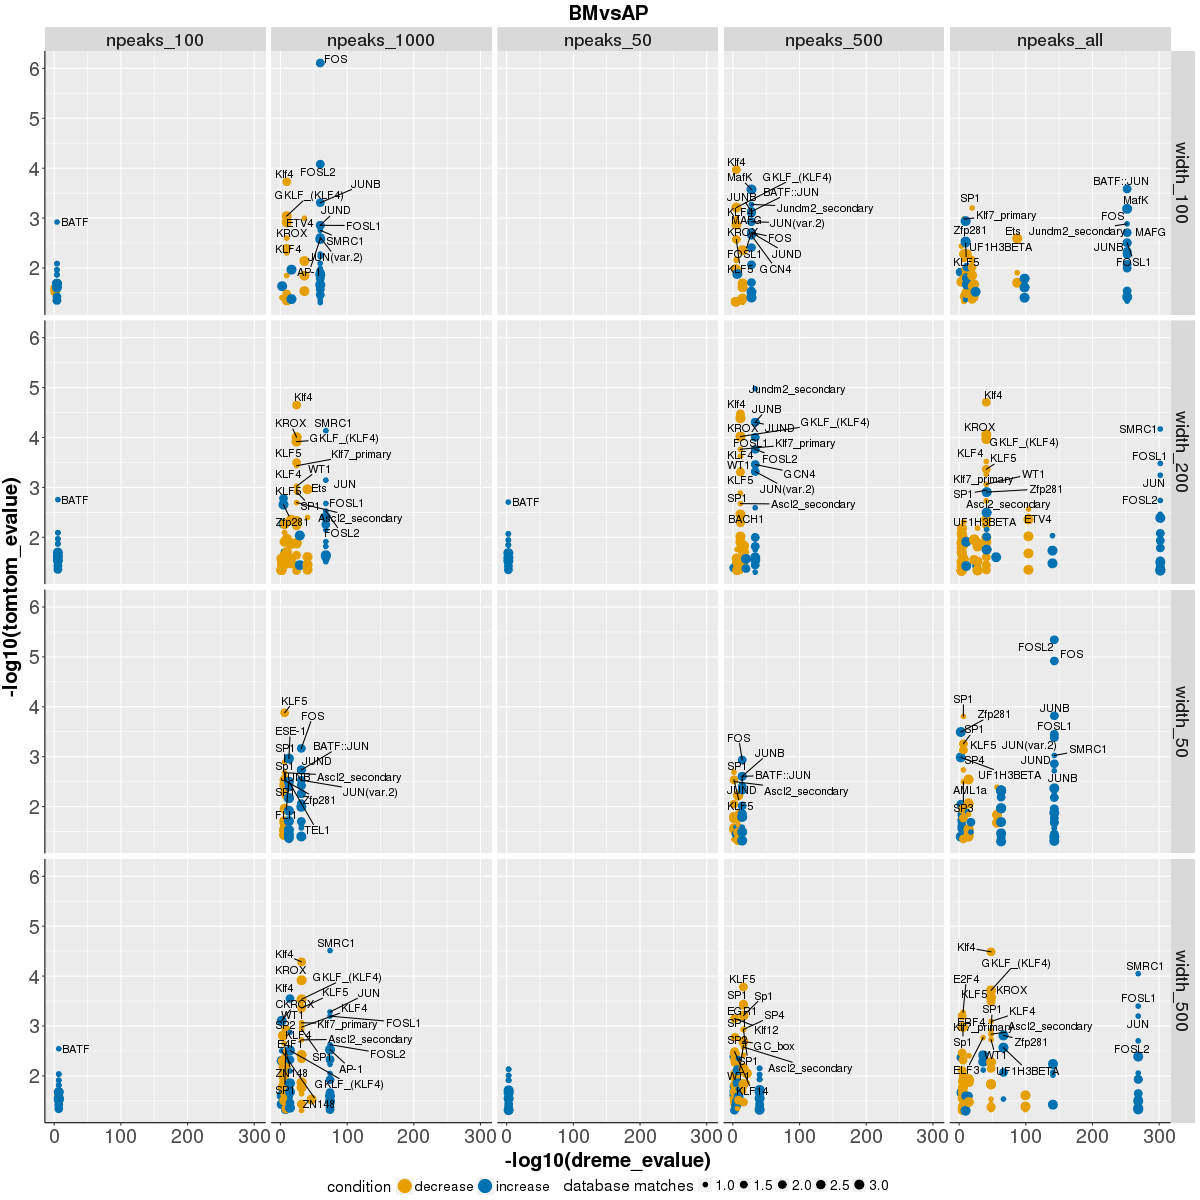

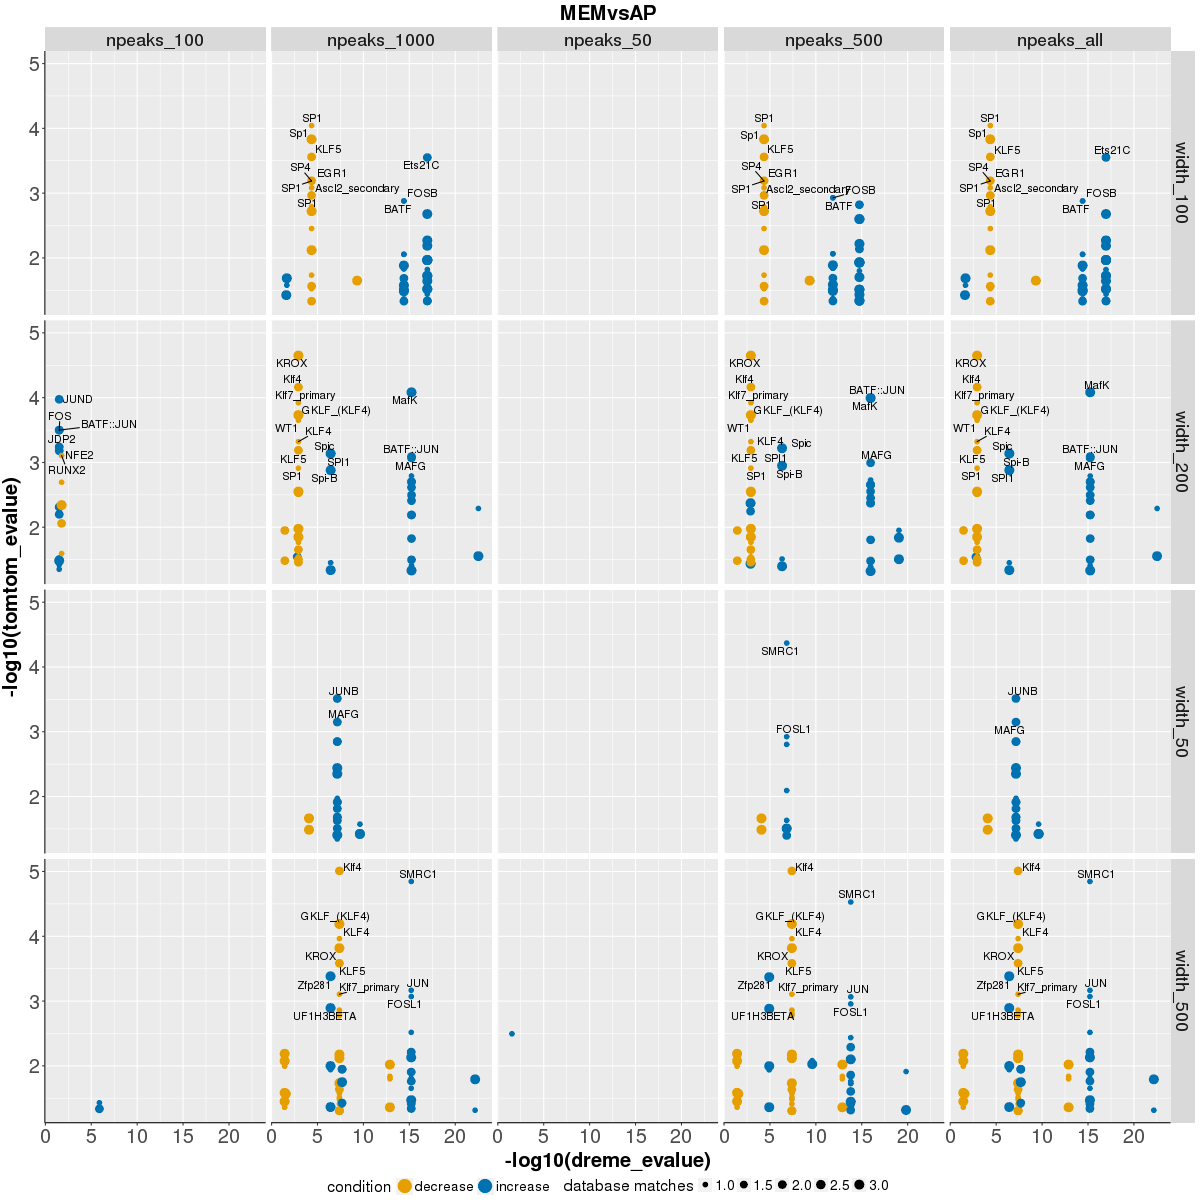

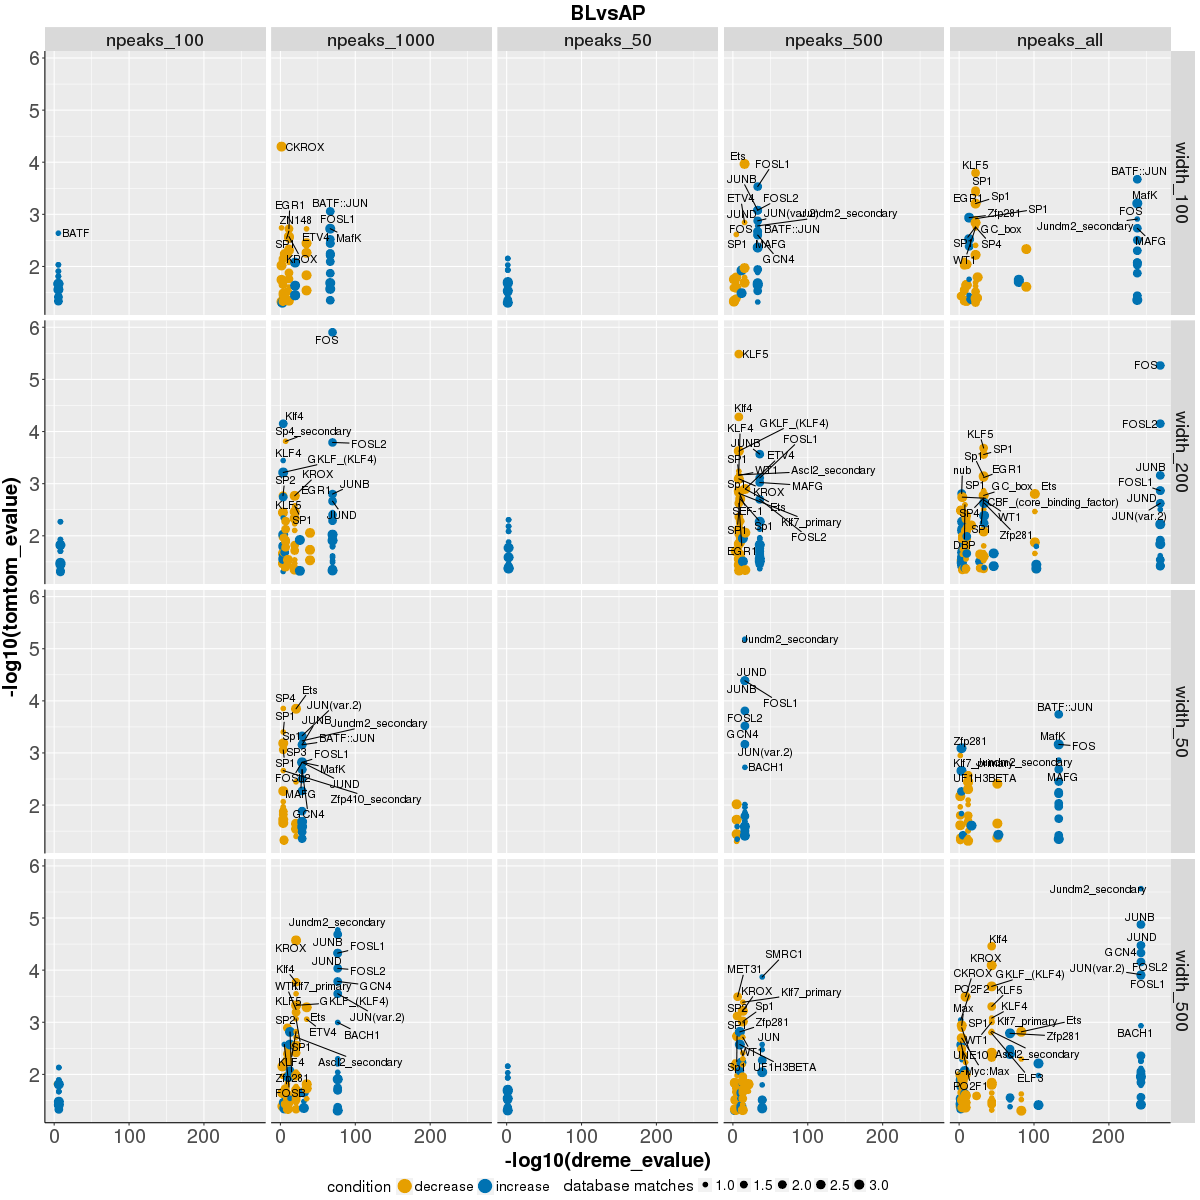

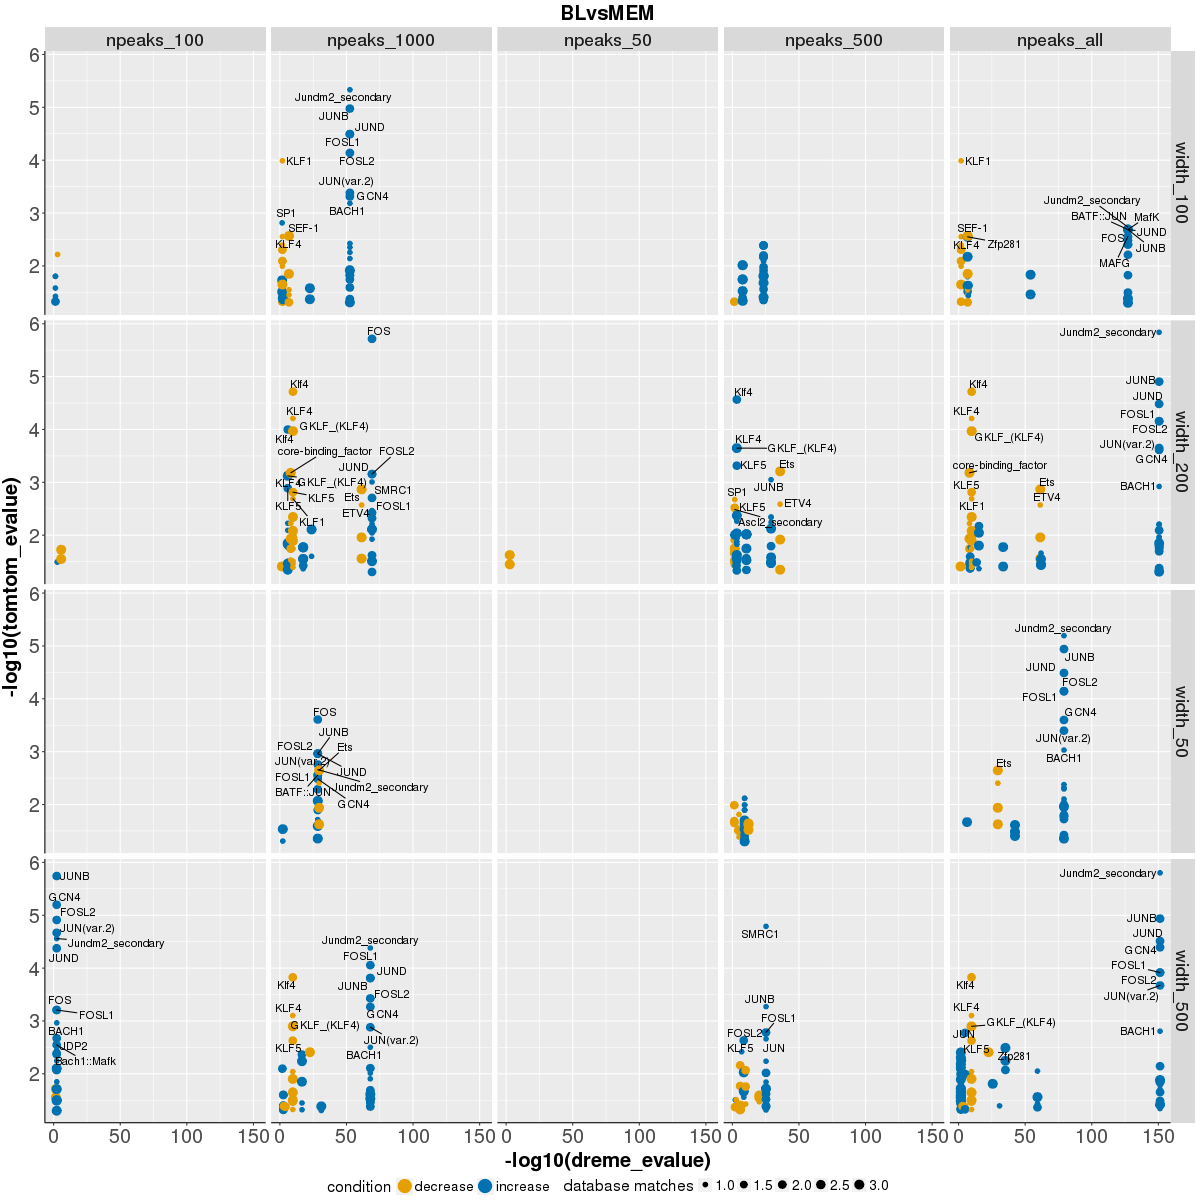

In [16]:
%%R -i dreme_graph -w 1200 -h 1200

for (comp in unique(dreme_graph$DESeq2_comparison)){
    df <- subset(dreme_graph, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), colour=condition)) +
        geom_point(aes(size=database), position=position_jitterdodge()) + 
        scale_size(range=c(2,4), name="database matches") +
        scale_alpha(range=c(0.4,1)) +
        geom_text_repel(data=df[-log10(df$"tomtom_evalue") > 
                                       quantile(-log10(df$"tomtom_evalue"), 0.8, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
        scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=6))) +
        guides(alpha=guide_legend(override.aes=list(size=6)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

## Top Motif Tables:
* Sorted by peak size & TOMTOM e-value

### Peaks with increased accessibility:

In [17]:
for i in dreme_chip["DESeq2_comparison"].unique():
    print i
    dreme_chip[(dreme_chip.DESeq2_comparison == i) & (dreme_chip.condition == "increase")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

BMvsAP


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
76900,TGASTMAB,VTKASTCA,301,33,2.000000e-60,BMvsAP_increase_1000_100,TGAGTCAG,MA0476.1,FOS,jaspar,7.803610e-07,-,BMvsAP,increase,1000,100,1000_100
76902,TGASTMAB,VTKASTCA,301,33,2.000000e-60,BMvsAP_increase_1000_100,TGAGTCAG,MA0478.1,FOSL2,jaspar,8.294430e-05,+,BMvsAP,increase,1000,100,1000_100
80920,TGAVTMA,TKABTCA,1572,296,1.100000e-252,BMvsAP_increase_all_100,TGACTCA,MA0462.1,BATF::JUN,jaspar,2.612340e-04,+,BMvsAP,increase,all,100,all_100
73740,TGASTMA,TKASTCA,151,17,1.500000e-28,BMvsAP_increase_500_100,TGACTCA,M02022,MafK,transfac,2.663200e-04,-,BMvsAP,increase,500,100,500_100
76904,TGASTMAB,VTKASTCA,301,33,2.000000e-60,BMvsAP_increase_1000_100,TGAGTCAG,MA0490.1,JUNB,jaspar,4.922170e-04,+,BMvsAP,increase,1000,100,1000_100
73743,TGASTMA,TKASTCA,151,17,1.500000e-28,BMvsAP_increase_500_100,TGACTCA,UP00103_2,Jundm2_secondary,uniprobe,5.326390e-04,-,BMvsAP,increase,500,100,500_100
73748,TGASTMA,TKASTCA,151,17,1.500000e-28,BMvsAP_increase_500_100,TGACTCA,MA0659.1,MAFG,jaspar,7.989590e-04,-,BMvsAP,increase,500,100,500_100
81580,CCCCDCCC,GGGHGGGG,213,83,1.900000e-10,BMvsAP_increase_all_100,CCCCACCC,M01597,Zfp281,transfac,1.146570e-03,-,BMvsAP,increase,all,100,all_100
73750,TGASTMA,TKASTCA,151,17,1.500000e-28,BMvsAP_increase_500_100,TGACTCA,MA0489.1,JUN(var.2),jaspar,1.183940e-03,+,BMvsAP,increase,500,100,500_100
71968,TGACTMA,TKAGTCA,31,2,7.400000e-05,BMvsAP_increase_100_100,TGACTCA,BATF_MOUSE.H10MO.B,BATF,hocomoco,1.201250e-03,-,BMvsAP,increase,100,100,100_100


BLvsAP


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
53360,TGAVTMA,TKABTCA,1384,234,1.200000e-238,BLvsAP_increase_all_100,TGACTCA,MA0462.1,BATF::JUN,jaspar,0.000212,+,BLvsAP,increase,all,100,all_100
46396,TGASTMA,TKASTCA,162,15,7.000000e-34,BLvsAP_increase_500_100,TGACTCA,MA0477.1,FOSL1,jaspar,0.000293,+,BLvsAP,increase,500,100,500_100
53362,TGAVTMA,TKABTCA,1384,234,1.200000e-238,BLvsAP_increase_all_100,TGACTCA,MA0476.1,FOS,jaspar,0.000615,-,BLvsAP,increase,all,100,all_100
53364,TGAVTMA,TKABTCA,1384,234,1.200000e-238,BLvsAP_increase_all_100,TGACTCA,M02022,MafK,transfac,0.000615,-,BLvsAP,increase,all,100,all_100
46398,TGASTMA,TKASTCA,162,15,7.000000e-34,BLvsAP_increase_500_100,TGACTCA,MA0478.1,FOSL2,jaspar,0.000832,+,BLvsAP,increase,500,100,500_100
46400,TGASTMA,TKASTCA,162,15,7.000000e-34,BLvsAP_increase_500_100,TGACTCA,MA0490.1,JUNB,jaspar,0.000832,+,BLvsAP,increase,500,100,500_100
46402,TGASTMA,TKASTCA,162,15,7.000000e-34,BLvsAP_increase_500_100,TGACTCA,MA0491.1,JUND,jaspar,0.000832,+,BLvsAP,increase,500,100,500_100
53960,CCCCDCCC,GGGHGGGG,197,61,4.300000e-14,BLvsAP_increase_all_100,CCCCACCC,M01597,Zfp281,transfac,0.001157,-,BLvsAP,increase,all,100,all_100
53367,TGAVTMA,TKABTCA,1384,234,1.200000e-238,BLvsAP_increase_all_100,TGACTCA,UP00103_2,Jundm2_secondary,uniprobe,0.001230,-,BLvsAP,increase,all,100,all_100
46404,TGASTMA,TKASTCA,162,15,7.000000e-34,BLvsAP_increase_500_100,TGACTCA,MA0489.1,JUN(var.2),jaspar,0.001331,+,BLvsAP,increase,500,100,500_100


BMvsMEM


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
29580,TGASTMAB,VTKASTCA,795,107,6.400000e-148,BMvsMEM_increase_all_100,TGACTCAG,MA0476.1,FOS,jaspar,0.000009,-,BMvsMEM,increase,all,100,all_100
29582,TGASTMAB,VTKASTCA,795,107,6.400000e-148,BMvsMEM_increase_all_100,TGACTCAG,MA0478.1,FOSL2,jaspar,0.000043,+,BMvsMEM,increase,all,100,all_100
29584,TGASTMAB,VTKASTCA,795,107,6.400000e-148,BMvsMEM_increase_all_100,TGACTCAG,MA0490.1,JUNB,jaspar,0.000211,+,BMvsMEM,increase,all,100,all_100
29586,TGASTMAB,VTKASTCA,795,107,6.400000e-148,BMvsMEM_increase_all_100,TGACTCAG,MA0477.1,FOSL1,jaspar,0.000662,+,BMvsMEM,increase,all,100,all_100
25888,TGASTMA,TKASTCA,266,41,8.600000e-44,BMvsMEM_increase_1000_100,TGACTCA,UP00103_2,Jundm2_secondary,uniprobe,0.000722,-,BMvsMEM,increase,1000,100,1000_100
29588,TGASTMAB,VTKASTCA,795,107,6.400000e-148,BMvsMEM_increase_all_100,TGACTCAG,MA0489.1,JUN(var.2),jaspar,0.000815,+,BMvsMEM,increase,all,100,all_100
25889,TGASTMA,TKASTCA,266,41,8.600000e-44,BMvsMEM_increase_1000_100,TGACTCA,MA0462.1,BATF::JUN,jaspar,0.000919,+,BMvsMEM,increase,1000,100,1000_100
25893,TGASTMA,TKASTCA,266,41,8.600000e-44,BMvsMEM_increase_1000_100,TGACTCA,M02022,MafK,transfac,0.000919,-,BMvsMEM,increase,1000,100,1000_100
25896,TGASTMA,TKASTCA,266,41,8.600000e-44,BMvsMEM_increase_1000_100,TGACTCA,MA0303.1,GCN4,jaspar,0.001083,-,BMvsMEM,increase,1000,100,1000_100
25898,TGASTMA,TKASTCA,266,41,8.600000e-44,BMvsMEM_increase_1000_100,TGACTCA,MA0659.1,MAFG,jaspar,0.001083,-,BMvsMEM,increase,1000,100,1000_100


BLvsMEM


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
5104,RTGASTMA,TKASTCAY,250,21,2.900000e-53,BLvsMEM_increase_1000_100,GTGACTCA,UP00103_2,Jundm2_secondary,uniprobe,0.000005,-,BLvsMEM,increase,1000,100,1000_100
5105,RTGASTMA,TKASTCAY,250,21,2.900000e-53,BLvsMEM_increase_1000_100,GTGACTCA,MA0490.1,JUNB,jaspar,0.000011,+,BLvsMEM,increase,1000,100,1000_100
5107,RTGASTMA,TKASTCAY,250,21,2.900000e-53,BLvsMEM_increase_1000_100,GTGACTCA,MA0477.1,FOSL1,jaspar,0.000032,+,BLvsMEM,increase,1000,100,1000_100
5109,RTGASTMA,TKASTCAY,250,21,2.900000e-53,BLvsMEM_increase_1000_100,GTGACTCA,MA0491.1,JUND,jaspar,0.000032,+,BLvsMEM,increase,1000,100,1000_100
5111,RTGASTMA,TKASTCAY,250,21,2.900000e-53,BLvsMEM_increase_1000_100,GTGACTCA,MA0478.1,FOSL2,jaspar,0.000073,+,BLvsMEM,increase,1000,100,1000_100
5113,RTGASTMA,TKASTCAY,250,21,2.900000e-53,BLvsMEM_increase_1000_100,GTGACTCA,MA0489.1,JUN(var.2),jaspar,0.000414,+,BLvsMEM,increase,1000,100,1000_100
5115,RTGASTMA,TKASTCAY,250,21,2.900000e-53,BLvsMEM_increase_1000_100,GTGACTCA,MA0303.1,GCN4,jaspar,0.000487,-,BLvsMEM,increase,1000,100,1000_100
5117,RTGASTMA,TKASTCAY,250,21,2.900000e-53,BLvsMEM_increase_1000_100,GTGACTCA,BACH1_MOUSE.H10MO.C,BACH1,hocomoco,0.000654,-,BLvsMEM,increase,1000,100,1000_100
5664,CCCRCCCC,GGGGYGGG,37,6,2.100000e-02,BLvsMEM_increase_1000_100,CCCACCCC,M01303,SP1,transfac,0.001535,-,BLvsMEM,increase,1000,100,1000_100
9269,TGABTMA,TKAVTCA,783,144,6.600000e-128,BLvsMEM_increase_all_100,TGACTCA,MA0462.1,BATF::JUN,jaspar,0.002054,+,BLvsMEM,increase,all,100,all_100


MEMvsAP


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
105760,GGAARY,RYTTCC,220,79,1.100000e-17,MEMvsAP_increase_1000_100,GGAAGT,MA0916.1,Ets21C,jaspar,0.000282,+,MEMvsAP,increase,1000,100,1000_100
103416,TGAGTMA,TKACTCA,92,14,1.400000e-12,MEMvsAP_increase_500_100,TGAGTCA,BATF_MOUSE.H10MO.B,BATF,hocomoco,0.001180,+,MEMvsAP,increase,500,100,500_100
103417,TGAGTMA,TKACTCA,92,14,1.400000e-12,MEMvsAP_increase_500_100,TGAGTCA,FOSB_MOUSE.H10MO.C,FOSB,hocomoco,0.001180,+,MEMvsAP,increase,500,100,500_100
105762,GGAARY,RYTTCC,220,79,1.100000e-17,MEMvsAP_increase_1000_100,GGAAGT,M02058,SAP1A_(elk4),transfac,0.002101,+,MEMvsAP,increase,1000,100,1000_100
102794,GGAARY,RYTTCC,197,71,1.800000e-15,MEMvsAP_increase_500_100,GGAAGT,M02055,ESE-1,transfac,0.002515,+,MEMvsAP,increase,500,100,500_100
102800,GGAARY,RYTTCC,197,71,1.800000e-15,MEMvsAP_increase_500_100,GGAAGT,M02068,ETV3,transfac,0.002515,+,MEMvsAP,increase,500,100,500_100
105765,GGAARY,RYTTCC,220,79,1.100000e-17,MEMvsAP_increase_1000_100,GGAAGT,MA0475.2,FLI1,jaspar,0.005372,+,MEMvsAP,increase,1000,100,1000_100
102803,GGAARY,RYTTCC,197,71,1.800000e-15,MEMvsAP_increase_500_100,GGAAGT,M02070,TEL1,transfac,0.006075,+,MEMvsAP,increase,500,100,500_100
105771,GGAARY,RYTTCC,220,79,1.100000e-17,MEMvsAP_increase_1000_100,GGAAGT,MA0076.2,ELK4,jaspar,0.006447,-,MEMvsAP,increase,1000,100,1000_100
105773,GGAARY,RYTTCC,220,79,1.100000e-17,MEMvsAP_increase_1000_100,GGAAGT,ETV4_MOUSE.H10MO.B,ETV4,hocomoco,0.006482,+,MEMvsAP,increase,1000,100,1000_100


### Peaks with decreased accessibility:

In [18]:
for i in dreme_chip["DESeq2_comparison"].unique():
    print i
    dreme_chip[(dreme_chip.DESeq2_comparison == i) & (dreme_chip.condition == "decrease")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

BMvsAP


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
86916,CMCRCCC,GGGYGKG,122,48,6.600000e-06,BMvsAP_decrease_500_100,CCCGCCC,MA0039.2,Klf4,jaspar,0.000107,-,BMvsAP,decrease,500,100,500_100
86918,CMCRCCC,GGGYGKG,122,48,6.600000e-06,BMvsAP_decrease_500_100,CCCGCCC,M01588,GKLF_(KLF4),transfac,0.000615,+,BMvsAP,decrease,500,100,500_100
94860,GCYCCGCC,GGCGGRGC,129,15,3.800000e-20,BMvsAP_decrease_all_100,GCCCCGCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,0.000627,-,BMvsAP,decrease,all,100,all_100
89968,MGGAAR,YTTCCK,399,137,1.200000e-36,BMvsAP_decrease_1000_100,AGGAAG,ETV4_MOUSE.H10MO.B,ETV4,hocomoco,0.001005,+,BMvsAP,decrease,1000,100,1000_100
86921,CMCRCCC,GGGYGKG,122,48,6.600000e-06,BMvsAP_decrease_500_100,CCCGCCC,KLF4_MOUSE.H10MO.C,KLF4,hocomoco,0.001020,-,BMvsAP,decrease,500,100,500_100
95492,CMCGCCC,GGGCGKG,158,58,4.100000e-08,BMvsAP_decrease_all_100,CCCGCCC,UP00093_1,Klf7_primary,uniprobe,0.001044,+,BMvsAP,decrease,all,100,all_100
90121,CMCRCCC,GGGYGKG,219,95,3.600000e-10,BMvsAP_decrease_1000_100,CCCGCCC,M00982,KROX,transfac,0.001218,+,BMvsAP,decrease,1000,100,1000_100
94624,MGGAAR,YTTCCK,926,324,7.300000e-88,BMvsAP_decrease_all_100,AGGAAG,M00971,Ets,transfac,0.002560,-,BMvsAP,decrease,all,100,all_100
86925,CMCRCCC,GGGYGKG,122,48,6.600000e-06,BMvsAP_decrease_500_100,CCCGCCC,MA0599.1,KLF5,jaspar,0.002683,+,BMvsAP,decrease,500,100,500_100
95772,CCCACCCM,KGGGTGGG,87,28,4.200000e-04,BMvsAP_decrease_all_100,CCCACCCC,ZN148_MOUSE.H10MO.D,ZN148,hocomoco,0.003647,-,BMvsAP,decrease,all,100,all_100


BLvsAP


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
63136,CCCKCCCC,GGGGMGGG,52,14,3.300000e-02,BLvsAP_decrease_1000_100,CCCTCCCC,M01175,CKROX,transfac,0.000050,+,BLvsAP,decrease,1000,100,1000_100
58680,SAGGAAR,YTTCCTS,135,29,2.600000e-16,BLvsAP_decrease_500_100,CAGGAAG,M00971,Ets,transfac,0.000108,-,BLvsAP,decrease,500,100,500_100
67144,CYCCDCCC,GGGHGGRG,315,108,1.100000e-22,BLvsAP_decrease_all_100,CCCCGCCC,MA0599.1,KLF5,jaspar,0.000161,+,BLvsAP,decrease,all,100,all_100
67146,CYCCDCCC,GGGHGGRG,315,108,1.100000e-22,BLvsAP_decrease_all_100,CCCCGCCC,MA0079.3,SP1,jaspar,0.000350,+,BLvsAP,decrease,all,100,all_100
67148,CYCCDCCC,GGGHGGRG,315,108,1.100000e-22,BLvsAP_decrease_all_100,CCCCGCCC,MA0162.2,EGR1,jaspar,0.000375,+,BLvsAP,decrease,all,100,all_100
67150,CYCCDCCC,GGGHGGRG,315,108,1.100000e-22,BLvsAP_decrease_all_100,CCCCGCCC,M00933,Sp1,transfac,0.000621,+,BLvsAP,decrease,all,100,all_100
67153,CYCCDCCC,GGGHGGRG,315,108,1.100000e-22,BLvsAP_decrease_all_100,CCCCGCCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,0.001213,-,BLvsAP,decrease,all,100,all_100
58683,SAGGAAR,YTTCCTS,135,29,2.600000e-16,BLvsAP_decrease_500_100,CAGGAAG,ETV4_MOUSE.H10MO.B,ETV4,hocomoco,0.001433,+,BLvsAP,decrease,500,100,500_100
67154,CYCCDCCC,GGGHGGRG,315,108,1.100000e-22,BLvsAP_decrease_all_100,CCCCGCCC,M00255,GC_box,transfac,0.001450,-,BLvsAP,decrease,all,100,all_100
67157,CYCCDCCC,GGGHGGRG,315,108,1.100000e-22,BLvsAP_decrease_all_100,CCCCGCCC,M01273,SP4,transfac,0.001746,+,BLvsAP,decrease,all,100,all_100


BMvsMEM


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
35092,AYTTCC,GGAART,79,27,1.300000e-03,BMvsMEM_decrease_500_100,ATTTCC,FEV_MOUSE.H10MO.C,FEV,hocomoco,0.003447,-,BMvsMEM,decrease,500,100,500_100
41324,CCCCWCCC,GGGWGGGG,72,16,9.300000e-06,BMvsMEM_decrease_all_100,CCCCACCC,M01597,Zfp281,transfac,0.004795,-,BMvsMEM,decrease,all,100,all_100
41327,CCCCWCCC,GGGWGGGG,72,16,9.300000e-06,BMvsMEM_decrease_all_100,CCCCACCC,M01068,UF1H3BETA,transfac,0.005760,-,BMvsMEM,decrease,all,100,all_100
37744,ACGTSA,TSACGT,59,10,1.200000e-05,BMvsMEM_decrease_1000_100,ACGTCA,ATF1_MOUSE.H10MO.B,ATF1,hocomoco,0.007329,+,BMvsMEM,decrease,1000,100,1000_100
37388,RRCCACA,TGTGGYY,177,66,3.300000e-10,BMvsMEM_decrease_1000_100,AACCACA,MA0002.2,RUNX1,jaspar,0.015538,-,BMvsMEM,decrease,1000,100,1000_100
35272,RACCACA,TGTGGTY,60,16,1.800000e-03,BMvsMEM_decrease_500_100,AACCACA,PEBB_MOUSE.H10MO.C,PEBB,hocomoco,0.016305,-,BMvsMEM,decrease,500,100,500_100
35273,RACCACA,TGTGGTY,60,16,1.800000e-03,BMvsMEM_decrease_500_100,AACCACA,M00984,PEBP,transfac,0.017254,+,BMvsMEM,decrease,500,100,500_100
35388,GGGWGGR,YCCWCCC,89,38,2.000000e-02,BMvsMEM_decrease_500_100,GGGTGGG,M01597,Zfp281,transfac,0.032861,+,BMvsMEM,decrease,500,100,500_100
41330,CCCCWCCC,GGGWGGGG,72,16,9.300000e-06,BMvsMEM_decrease_all_100,CCCCACCC,MA0599.1,KLF5,jaspar,0.037936,+,BMvsMEM,decrease,all,100,all_100
34452,CTTCCB,VGGAAG,49,13,2.900000e-04,BMvsMEM_decrease_100_100,CTTCCT,M02076,Spi-B,transfac,0.039193,-,BMvsMEM,decrease,100,100,100_100


BLvsMEM


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
17216,GCCMCACC,GGTGKGGC,33,4,1.300000e-02,BLvsMEM_decrease_1000_100,GCCCCACC,KLF1_MOUSE.H10MO.C,KLF1,hocomoco,0.000103,-,BLvsMEM,decrease,1000,100,1000_100
17040,DACCACA,TGTGGTH,122,40,1.600000e-07,BLvsMEM_decrease_1000_100,AACCACA,M00214,SEF-1,transfac,0.002712,-,BLvsMEM,decrease,1000,100,1000_100
17217,GCCMCACC,GGTGKGGC,33,4,1.300000e-02,BLvsMEM_decrease_1000_100,GCCCCACC,KLF4,KLF4,chen,0.002798,-,BLvsMEM,decrease,1000,100,1000_100
17218,GCCMCACC,GGTGKGGC,33,4,1.300000e-02,BLvsMEM_decrease_1000_100,GCCCCACC,KLF3_MOUSE.H10MO.D,KLF3,hocomoco,0.004023,-,BLvsMEM,decrease,1000,100,1000_100
17219,GCCMCACC,GGTGKGGC,33,4,1.300000e-02,BLvsMEM_decrease_1000_100,GCCCCACC,MA0039.2,Klf4,jaspar,0.004948,-,BLvsMEM,decrease,1000,100,1000_100
13620,GGAAGB,VCTTCC,41,9,1.200000e-03,BLvsMEM_decrease_100_100,GGAAGT,ELF2_MOUSE.H10MO.C,ELF2,hocomoco,0.006082,+,BLvsMEM,decrease,100,100,100_100
17221,GCCMCACC,GGTGKGGC,33,4,1.300000e-02,BLvsMEM_decrease_1000_100,GCCCCACC,MA0493.1,Klf1,jaspar,0.008096,+,BLvsMEM,decrease,1000,100,1000_100
17223,GCCMCACC,GGTGKGGC,33,4,1.300000e-02,BLvsMEM_decrease_1000_100,GCCCCACC,KLF4_MOUSE.H10MO.C,KLF4,hocomoco,0.010120,-,BLvsMEM,decrease,1000,100,1000_100
17043,DACCACA,TGTGGTH,122,40,1.600000e-07,BLvsMEM_decrease_1000_100,AACCACA,M00722,core-binding_factor,transfac,0.014170,-,BLvsMEM,decrease,1000,100,1000_100
17224,GCCMCACC,GGTGKGGC,33,4,1.300000e-02,BLvsMEM_decrease_1000_100,GCCCCACC,M01588,GKLF_(KLF4),transfac,0.022510,+,BLvsMEM,decrease,1000,100,1000_100


MEMvsAP


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,condition,no_peaks,window,settings
112464,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,M01303,SP1,transfac,0.000091,-,MEMvsAP,decrease,500,100,500_100
112465,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,M00933,Sp1,transfac,0.000147,+,MEMvsAP,decrease,500,100,500_100
112468,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,MA0599.1,KLF5,jaspar,0.000276,+,MEMvsAP,decrease,500,100,500_100
112470,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,MA0162.2,EGR1,jaspar,0.000644,+,MEMvsAP,decrease,500,100,500_100
112472,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,0.000650,-,MEMvsAP,decrease,500,100,500_100
112473,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,M01273,SP4,transfac,0.000650,+,MEMvsAP,decrease,500,100,500_100
112474,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,UP00099_2,Ascl2_secondary,uniprobe,0.000828,+,MEMvsAP,decrease,500,100,500_100
112475,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,MA0079.3,SP1,jaspar,0.001084,+,MEMvsAP,decrease,500,100,500_100
112477,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,WT1_MOUSE.H10MO.D,WT1,hocomoco,0.001626,-,MEMvsAP,decrease,500,100,500_100
112478,CCCCDCCC,GGGHGGGG,46,6,0.000044,MEMvsAP_decrease_500_100,CCCCGCCC,M00982,KROX,transfac,0.001897,+,MEMvsAP,decrease,500,100,500_100
